In [1]:
import astir
import anndata as ad
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import yaml
from pprint import pprint 
from sklearn.metrics import classification_report, confusion_matrix

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
# Load train data and transform it to pandas DataFrame
train_anndata_path = 'IMC-models/data/train_adata.h5ad'
train_ad = ad.read(train_anndata_path)

X_train = train_ad.layers['exprs']
df_train = pd.DataFrame(X_train, index=train_ad.obs['cell_labels'], columns=train_ad.var['marker'])
df_train

marker,MPO,HistoneH3,SMA,CD16,CD38,HLADR,CD27,CD15,CD45RA,CD163,...,VISTA,CD40,CD4,CD14,Ecad,CD303,CD206,cleavedPARP,DNA1,DNA2
cell_labels,,,,,,,,,,,,,,,,,,,,,
MacCD163,0.000000,1.819988,0.502650,1.265410,0.515007,3.331261,0.403800,0.455421,0.528734,2.948392,...,0.792218,0.567238,1.651610,2.556218,0.777378,0.000000,3.581082,0.424273,4.761130,5.301351
Mural,0.135920,2.393087,1.136961,0.505529,0.605836,0.710857,0.419814,0.100110,0.743002,0.329851,...,0.530987,0.603468,1.358368,1.700181,1.884778,0.068872,0.744634,0.118620,5.029241,5.530764
DC,0.165905,2.244917,1.396334,1.744382,0.458541,4.006500,0.003607,0.562882,1.236516,1.747839,...,0.449097,0.812795,1.949510,3.465199,1.743507,0.403610,2.244398,0.015141,4.418390,4.815923
Tumor,0.165905,1.144778,0.563216,1.166010,0.513735,2.034705,0.650242,0.250150,1.205007,0.990385,...,1.866916,1.228290,2.287524,2.491710,2.268924,0.196199,0.946492,0.233095,3.736089,4.368012
Tumor,0.137497,2.210970,0.892371,0.497646,0.412840,1.499184,0.098131,0.208566,0.922874,1.255892,...,0.806346,0.360098,1.445085,2.332546,2.387292,0.061568,1.632904,0.372278,4.607359,5.152041
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Mural,0.223930,5.665851,2.734667,2.338794,0.853400,1.660905,1.660581,1.202203,1.322045,0.789409,...,0.402421,0.151767,0.820879,1.591254,1.382112,0.813415,0.531336,0.034725,4.334035,4.838697
Mural,0.149443,3.908886,2.751400,0.702922,0.539905,0.435384,0.557881,0.146520,0.402526,0.317224,...,0.149241,0.069210,0.256412,1.246646,1.200277,0.230447,0.203544,0.000000,4.633061,5.182098
CD8,0.110884,3.520289,0.310834,2.590231,2.336469,3.652604,1.443007,0.248852,0.455855,1.025672,...,0.667975,0.434373,1.868607,2.931921,1.427727,0.994726,0.224414,0.102515,4.303070,4.826098


In [17]:
# load marker yaml file
marker_yaml_path = 'astir_celltypes.yml'
with open(marker_yaml_path, 'r') as f:
    marker_yaml = yaml.safe_load(f)
pprint(marker_yaml)

{'cell_type': {'B': ['CD20'],
               'BnT': ['CD20', 'CD3'],
               'CD4': ['CD3', 'CD4'],
               'CD8': ['CD3', 'CD8a'],
               'DC': ['CD11c'],
               'HLADR': ['HLADR'],
               'MacCD163': ['CD163'],
               'Mural': ['SMA', 'PDGFRb'],
               'NK': ['CD7'],
               'Neutrophil': ['CD15', 'MPO'],
               'Treg': ['CD3', 'FOXP3'],
               'Tumor': ['Ecad'],
               'pDC': ['CD303'],
               'plasma': ['CD38']}}


In [18]:
ast_obj = astir.astir.Astir(df_train, marker_yaml, random_seed=0)
ast_obj.normalize()

In [19]:
ast_obj.fit_type(max_epochs=100, n_init=5, n_init_epochs=5)

training restart (final):   1%|          | 1/100 [15.45s/epochs, current loss: -2721842.6]


Text(0.5, 0, 'Epoch')

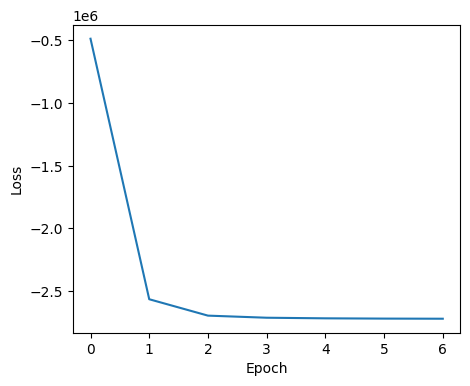

In [25]:
plt.figure(figsize=(5,4))
plt.plot(np.arange(len(ast_obj.get_type_losses())), ast_obj.get_type_losses())
plt.ylabel("Loss")
plt.xlabel("Epoch")

In [21]:
assignments = ast_obj.get_celltype_probabilities()
assignments

,B,BnT,CD4,CD8,Treg,Neutrophil,MacCD163,DC,Tumor,HLADR,Mural,pDC,plasma,NK,Other
MacCD163,0.096916,0.228398,5.751662e-07,1.093657e-10,4.628937e-07,1.570616e-15,0.095874,0.092591,0.024273,0.092477,1.245539e-04,0.087833,0.094535,0.092223,0.094755
Mural,0.081386,0.098924,1.433045e-04,6.754841e-06,2.474810e-02,5.704284e-13,0.080677,0.080931,0.042240,0.079986,1.998139e-01,0.072113,0.080077,0.078328,0.080626
DC,0.072999,0.070167,3.493956e-04,1.738410e-05,8.578036e-02,1.301810e-12,0.076102,0.075980,0.034644,0.075087,2.138566e-01,0.070391,0.074626,0.073406,0.076593
Tumor,0.066185,0.077188,4.128357e-04,3.838810e-04,3.678233e-01,6.292727e-13,0.065577,0.063921,0.039340,0.064716,3.148703e-04,0.059313,0.064700,0.064317,0.065808
Tumor,0.102606,0.106550,2.027061e-04,4.219437e-05,1.475588e-02,4.581977e-13,0.103298,0.099157,0.071306,0.099927,2.210769e-03,0.094614,0.101351,0.100705,0.103276
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Mural,0.000020,0.000028,4.798483e-09,3.109615e-12,5.116671e-10,6.851110e-15,0.000020,0.000021,0.000008,0.000020,9.998001e-01,0.000021,0.000021,0.000020,0.000021
Mural,0.000005,0.000009,3.985433e-11,4.050857e-14,3.782110e-12,4.255916e-17,0.000005,0.000005,0.000002,0.000005,9.999475e-01,0.000005,0.000005,0.000005,0.000005
CD8,0.000028,0.000002,2.328853e-03,9.974415e-01,1.740328e-06,1.898874e-15,0.000027,0.000028,0.000011,0.000028,1.000036e-07,0.000025,0.000027,0.000025,0.000026
Mural,0.000031,0.000059,1.403313e-10,7.858062e-14,9.679016e-10,3.714736e-16,0.000031,0.000030,0.000009,0.000031,9.996869e-01,0.000031,0.000031,0.000031,0.000031


In [31]:
pred_labels = ast_obj.get_celltypes(assignment_type='max')
pred_labels

,cell_type
MacCD163,BnT
Mural,Mural
DC,Mural
Tumor,Treg
Tumor,BnT
...,...
Mural,Mural
Mural,Mural
CD8,CD8
Mural,Mural


/opt/miniconda3/envs/astir/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/astir/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/astir/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           B       0.29      0.35      0.32      3731
         BnT       0.00      0.00      0.00      6493
         CD4       0.71      0.86      0.78     13238
         CD8       0.66      0.98      0.79     22722
          DC       0.25      0.16      0.20      4921
       HLADR       0.27      0.07      0.12      3925
    MacCD163       0.60      0.06      0.12     15288
       Mural       0.49      0.51      0.50     20537
          NK       0.13      0.06      0.08      1112
  Neutrophil       0.83      0.94      0.88      7386
       Other       0.00      0.00      0.00         0
        Treg       0.31      0.83      0.45      6381
       Tumor       0.98      0.40      0.57    138266
         pDC       0.04      0.10      0.06      1561
      plasma       0.00      0.00      0.00      7872

    accuracy                           0.46    253433
   macro avg       0.37      0.36      0.32    253433
weighted avg       0.75   

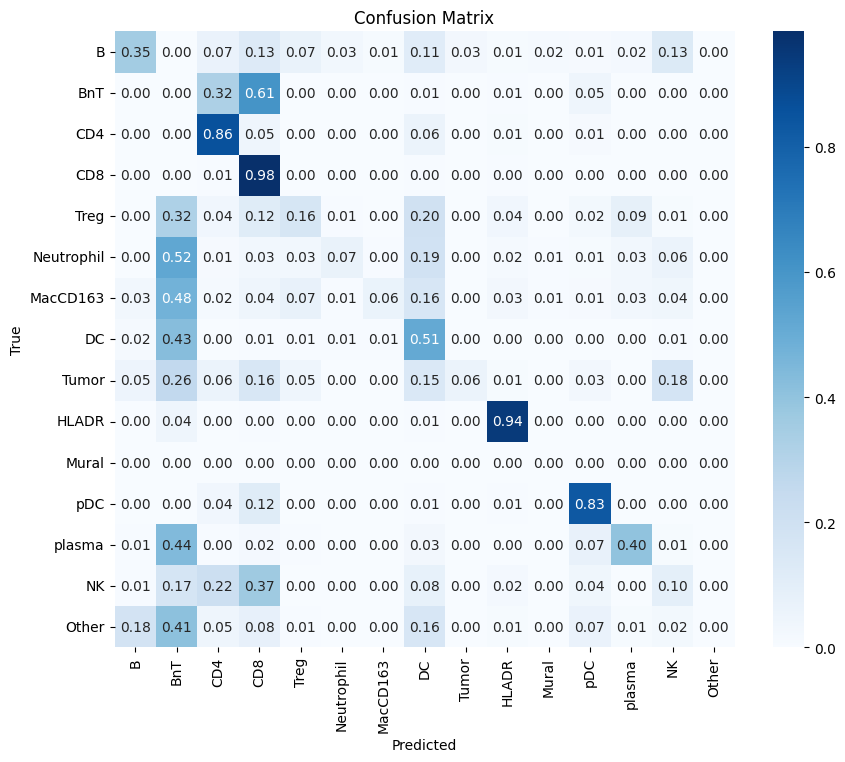

In [32]:
print(classification_report(assignments.index, pred_labels))
cf = confusion_matrix(assignments.index, pred_labels, normalize='true')
fig = plt.figure(figsize=(10, 8))
sns.heatmap(cf, annot=True, fmt='.2f', cmap='Blues', xticklabels=assignments.columns, yticklabels=assignments.columns)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [27]:
ast_obj.diagnostics_celltype()

,feature,should be expressed higher in,than,mean cell type 1,mean cell type 2,p-value,note
0,CD20,BnT,CD4,0.090642,0.222363,0.313149,None
1,CD20,BnT,CD8,0.090642,0.222576,0.300153,None
2,CD20,BnT,Treg,0.090642,0.239691,0.081616,None
3,CD20,BnT,Neutrophil,0.090642,0.135157,0.460130,None
4,CD20,BnT,Mural,0.090642,0.133481,0.522171,None
5,CD3,BnT,Neutrophil,0.037615,0.163272,0.086573,None
6,CD3,BnT,Mural,0.037615,0.155791,0.080526,None
7,CD4,CD4,BnT,0.509425,0.407881,0.086039,None
8,FOXP3,Treg,BnT,0.379798,0.204577,0.012228,None
9,PDGFRb,Mural,BnT,0.361130,0.213391,0.083475,None


In [28]:
# evaluation
test_anndata_path = 'IMC-models/data/test_adata.h5ad'
test_ad = ad.read(test_anndata_path)

X_test = test_ad.layers['exprs']
df_test = pd.DataFrame(X_test, index=test_ad.obs['cell_labels'], columns=test_ad.var['marker'])
df_test

marker,MPO,HistoneH3,SMA,CD16,CD38,HLADR,CD27,CD15,CD45RA,CD163,...,VISTA,CD40,CD4,CD14,Ecad,CD303,CD206,cleavedPARP,DNA1,DNA2
cell_labels,,,,,,,,,,,,,,,,,,,,,
DC,0.153216,2.983444,1.371527,1.410795,0.000000,4.193768,0.000000,0.324737,0.318286,0.240997,...,0.070715,0.663024,1.617993,2.762249,0.900169,0.000000,0.141936,0.000000,5.093765,5.613452
Tumor,0.198690,2.306174,0.599260,0.345263,0.064365,0.992633,0.305452,1.331774,0.253683,0.193908,...,0.283506,0.542449,0.666764,2.119486,0.937696,0.213429,0.131937,0.338624,4.510022,5.107309
Tumor,0.199321,2.018642,1.413792,0.832435,0.000000,1.426830,0.851860,0.201242,0.771629,0.261073,...,0.612881,0.915450,1.181813,2.311729,2.257665,0.000000,0.268533,0.073191,4.312676,4.977469
Tumor,0.198690,2.850586,1.032942,0.607633,0.216687,1.603235,0.339752,0.211800,0.466194,0.025095,...,0.398077,0.761372,1.002280,1.368747,1.379147,0.151605,0.377399,0.181820,5.138353,5.750130
Tumor,0.071368,2.337856,1.582033,0.386124,0.207548,0.640380,0.348225,1.143001,0.902172,0.244002,...,0.159723,0.889207,0.756276,1.362798,1.273236,0.102940,0.068857,0.060148,4.932845,5.412246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Tumor,0.424624,2.962833,0.000000,0.300195,0.832976,0.516495,0.506011,0.054082,0.373977,0.164956,...,0.601011,0.000000,0.525580,0.400579,2.609827,0.188648,0.000000,0.032576,4.193187,4.788816
Tumor,0.238634,3.098678,0.636815,0.234884,1.169920,0.367526,0.313803,0.574464,0.207993,0.000000,...,0.375963,0.094164,1.033641,1.548906,3.644230,0.665811,0.230013,0.000000,5.007821,5.561784
Tumor,0.099834,2.397878,0.655885,0.645747,1.431659,0.369573,0.308375,0.323851,0.742559,0.194913,...,0.851149,0.247818,1.331511,1.286361,3.239332,1.571598,1.077621,0.215462,3.583384,4.078217


In [39]:
test_dst = astir.data.SCDataset(df_test, marker_yaml['cell_type'], include_other_column=False)
test_dst.normalize()

In [55]:
_, test_exprs, _ = test_dst[:]

test_preds = ast_obj._type_ast._recog(test_exprs)[0].detach().cpu().numpy()
test_assignments = pd.DataFrame(test_preds, index=df_test.index, columns=assignments.columns)
test_assignments

,B,BnT,CD4,CD8,Treg,Neutrophil,MacCD163,DC,Tumor,HLADR,Mural,pDC,plasma,NK,Other
cell_labels,,,,,,,,,,,,,,,
DC,0.051718,0.048939,0.000016,2.251797e-07,1.462103e-04,9.618103e-11,0.053802,0.058467,0.022803,0.055358,4.974468e-01,0.050405,0.054073,0.052154,0.054671
Tumor,0.107138,0.109712,0.000004,2.708446e-08,5.990302e-08,1.094198e-09,0.105690,0.101820,0.048680,0.103194,1.990206e-04,0.106186,0.105510,0.105874,0.105992
Tumor,0.080444,0.083253,0.000009,3.038470e-04,1.665733e-05,5.008785e-10,0.080623,0.077654,0.080645,0.078304,1.985549e-01,0.078796,0.079910,0.080259,0.081229
Tumor,0.104948,0.083932,0.000018,2.669279e-07,2.524832e-07,4.781518e-10,0.104562,0.108173,0.063144,0.104516,1.230681e-02,0.102621,0.106323,0.103839,0.105617
Tumor,0.051900,0.027087,0.000343,1.243543e-05,6.637706e-05,6.936147e-11,0.052462,0.051998,0.031006,0.050675,5.272635e-01,0.050110,0.052373,0.051809,0.052894
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Tumor,0.095316,0.141055,0.000005,1.767031e-08,2.713291e-05,1.812322e-07,0.091097,0.089943,0.129223,0.090454,9.787807e-07,0.089587,0.092174,0.090847,0.090271
Tumor,0.084035,0.167960,0.000003,4.714684e-08,1.183479e-05,5.563768e-10,0.079211,0.080184,0.191431,0.077950,1.077952e-04,0.078913,0.081947,0.079099,0.079146
Tumor,0.081919,0.206637,0.000030,3.581491e-07,4.495502e-04,9.865947e-12,0.078472,0.080785,0.153811,0.076892,1.451487e-04,0.081292,0.081823,0.079026,0.078718


/opt/miniconda3/envs/astir/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/astir/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/astir/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           B       0.24      0.28      0.26      2767
         BnT       0.00      0.00      0.00      3341
         CD4       0.67      0.88      0.76      6139
         CD8       0.56      0.99      0.72      6890
          DC       0.33      0.27      0.30      2048
       HLADR       0.55      0.02      0.04      1627
    MacCD163       0.86      0.07      0.13      6482
       Mural       0.66      0.64      0.65      8977
          NK       0.19      0.06      0.09       498
  Neutrophil       0.76      0.99      0.86      2633
       Other       0.00      0.00      0.00         0
        Treg       0.34      0.83      0.49      1903
       Tumor       0.94      0.69      0.80     41456
         pDC       0.05      0.21      0.09       843
      plasma       0.00      0.00      0.00      4199

    accuracy                           0.59     89803
   macro avg       0.41      0.40      0.34     89803
weighted avg       0.71   

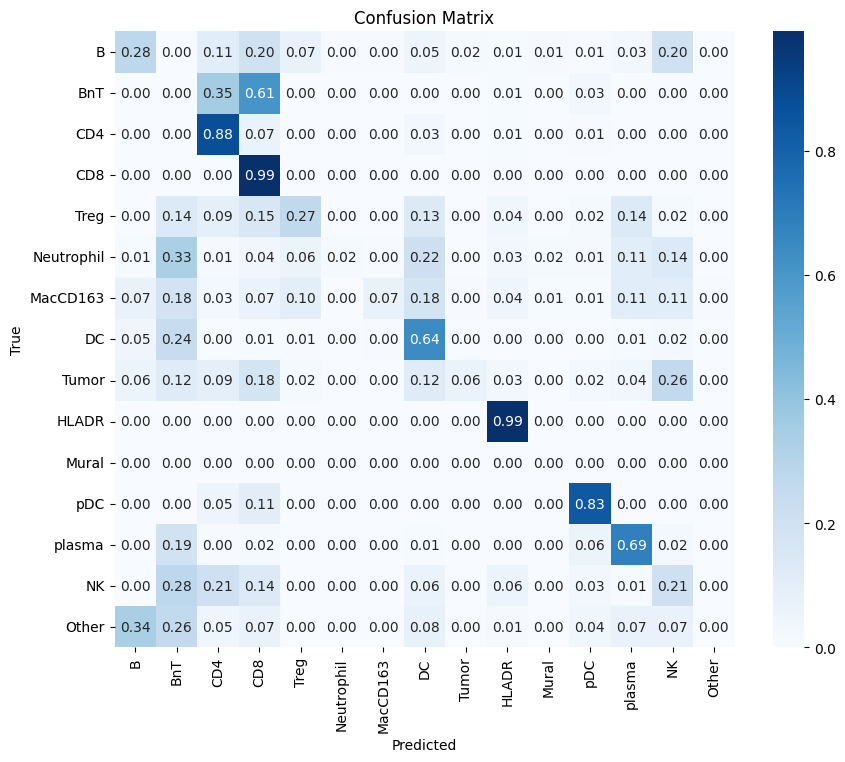

In [56]:
test_pred_labels = np.argmax(test_preds, axis=1)

test_pred_labels = [assignments.columns[i] for i in test_pred_labels]
print(classification_report(test_assignments.index, test_pred_labels))
cf_test = confusion_matrix(test_assignments.index, test_pred_labels, normalize='true')
fig = plt.figure(figsize=(10, 8))
sns.heatmap(cf_test, annot=True, fmt='.2f', cmap='Blues', xticklabels=assignments.columns, yticklabels=assignments.columns)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [60]:
test_assignments['pred_labels'] = test_pred_labels
# move pred_labels to the first column
cols = test_assignments.columns.tolist()
cols = cols[-1:] + cols[:-1]
test_assignments = test_assignments[cols]
test_assignments

,pred_labels,B,BnT,CD4,CD8,Treg,Neutrophil,MacCD163,DC,Tumor,HLADR,Mural,pDC,plasma,NK,Other
cell_labels,,,,,,,,,,,,,,,,
DC,Mural,0.051718,0.048939,0.000016,2.251797e-07,1.462103e-04,9.618103e-11,0.053802,0.058467,0.022803,0.055358,4.974468e-01,0.050405,0.054073,0.052154,0.054671
Tumor,BnT,0.107138,0.109712,0.000004,2.708446e-08,5.990302e-08,1.094198e-09,0.105690,0.101820,0.048680,0.103194,1.990206e-04,0.106186,0.105510,0.105874,0.105992
Tumor,Mural,0.080444,0.083253,0.000009,3.038470e-04,1.665733e-05,5.008785e-10,0.080623,0.077654,0.080645,0.078304,1.985549e-01,0.078796,0.079910,0.080259,0.081229
Tumor,DC,0.104948,0.083932,0.000018,2.669279e-07,2.524832e-07,4.781518e-10,0.104562,0.108173,0.063144,0.104516,1.230681e-02,0.102621,0.106323,0.103839,0.105617
Tumor,Mural,0.051900,0.027087,0.000343,1.243543e-05,6.637706e-05,6.936147e-11,0.052462,0.051998,0.031006,0.050675,5.272635e-01,0.050110,0.052373,0.051809,0.052894
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Tumor,BnT,0.095316,0.141055,0.000005,1.767031e-08,2.713291e-05,1.812322e-07,0.091097,0.089943,0.129223,0.090454,9.787807e-07,0.089587,0.092174,0.090847,0.090271
Tumor,Tumor,0.084035,0.167960,0.000003,4.714684e-08,1.183479e-05,5.563768e-10,0.079211,0.080184,0.191431,0.077950,1.077952e-04,0.078913,0.081947,0.079099,0.079146
Tumor,BnT,0.081919,0.206637,0.000030,3.581491e-07,4.495502e-04,9.865947e-12,0.078472,0.080785,0.153811,0.076892,1.451487e-04,0.081292,0.081823,0.079026,0.078718


In [61]:
test_assignments.to_csv('astir_test_assignments.tsv', sep='\t')

In [62]:
ast_obj.save_models('astir_model.hdf5')